# Classification using pretrained, well-known models
This notebook aims to create a set of benchmarks for the project, using well-known, thoroughly studied models.
Either with pretrained weights, or training with new data.

## Notes
### 21.08.19
Attempting to classify with VGG has not proven effective yet.
Initially, the image data was note scaled at all. Implemented scaling in the
import function, using min-max scaling of the value. This preserves the inherent
intensity difference between images.

The number of layers of VGG16 used is varied between 3 to 9 without noticable
difference. Attempting to find out why, by analyzing the extracted features.
The idea is that in order to classify, the feature distribution should be
different for images containing single and double events.
I first attempt this with manual qualitative inspection.

Manual, qualitative inspection reveals that the distributions look very similar.
Performing a quantitative study using Kolmogorov-Smirnov two-sample test,
comparing the distribution for each feature.

* For 1 block (depth 3), the pvalue returned from comparisons is 1.0 for all features.
* For 2 blocks (depth 6), the pvalue returned from comparisons is 1.0 for all features.
* For 3 blocks (depth 10), the pvalue returned from comparisons is 1.0 for all features.
* For 4 blocks, (depth 14) the pvalue returned from comparisons is 1.0 for all features.
* For 5 blocks, (depth 18) the pvalue returned from comparisons is 1.0 for all features.

This indicates that extracting features using vgg16 doesn't work for classification.
I still want to confirm that the weights of the vgg layers are the imagenet weights.

### 22.08.19
Going to use a reference image from imagenet to verify that the vgg-layers behave
as expected.
* Reference produces very similar feature output as simulated data

Rewrote the vgg_model script to be able to import any pretrained model from
tensorflow, and extended data import to handle single files (for large file)
and possibility to specify number of samples to include.

### 23.08.19
Import scripts fixed so that array dimensions are correct independent of folder or single
file import.

Tests on multiple nets with 10k events give same results as for VGG.

### 24.08.19
Running checks on feature distribution with the full networks and 200k events.
With 200k events there are models which from the p-value given by the KS two-sample test
should be possible to classify with. Interstingly, VGG16 and VGG19 show a large variance in which
features are seemingly drawn from different distributions.

Need to run for: NASNetLarge, ResNet50 and Xception, but running into memory problems.

### 25.08.19
Some NaN values in output features from VGG. When removed, the network trains to acc = 0.9
on the features. 

Implemented save_feature_representation and load_feature_representation.

### 04.09.19
Storing 200k events to use for generating feature representations for classification.

### 09.09.19
Previously trained fully connected nets on the feature output from all pretrained networks available
at full depth. The fully-connected nets were configured so that the input layer had a number of nodes
equal to the number of features output from the convolutional block before it (because the input shape
must be defined). After that, two layers of 512 nodes with RELu actication functions, into one
2-node layer with softmax.
Results:
* __DenseNet121__: 
    Accuracy starts around 0.86 first epoch and rises to just under 0.94 at maximum.
    Somewhat unstable.
* __DenseNet169__: 
    Very similar to DenseNet121, but starts at around 0.90
* __DenseNet201__: 
    Very similar to other two DenseNets, but more stable above 0.92 for epoch 4+.
* __InceptionResNetV2__: 
    Starts at 0.84, maxes just above 0.88. A bit zig-zag.
* __InceptionV3__: 
    Similar to V2 above, but starts lower and maxes out higher (0.90). Huge dip at epoch 7,
    around same spot as DenseNets.
* __MobileNet__: 
    Didn't learn anything.
* __MobileNetV2__: 
    Didn't learn anything.
* __NASNetLarge__: 
    Starts at 0.88, maxes out at 0.92 ish. Stable nice increase in accuracy with small dip at last epoch.
* __NASNetMobile__: 
    Roughly same as NASNetLarge, but a little more zig-zag in the curve.
* __ResNet50__: 
    Didn't learn anything.
* __VGG16__: 
    A lot of zig-zag, but between 0.88 and just under 0.92 (max), so it's a small span.
    Stops zig-zagging on max and becomes pretty much flat.
* __VGG19__: 
    Smaller zig-zag distances, steady increase up to around 0.90 for maximum.
* __Xception__: 
    Starts high (0.88) and slowly rises to a maximum of 0.92, a dip around epoch 6 like many others.
    
From this I think the nets that didn't weren't able to extract anything from the features can be
ignored for a while, to focus on those that performed well. This leaves the following nets as possible
points of interest:
* DenseNet201 (best of the DenseNets, keep the others in mind)
* NASNetLarge (keep NASNetMobile in mind)
* VGG16
* VGG19
* Xception

### 15.09.19
Simple implementation of distance-checking of double events done.
Results indicate that the model struggles more with events that are close together.
Specifically, I've looked at the ratio of correctly classified double events where
the events are less than 3mm apart.

### 16.09.19
* Compare feature distributions of single events and double events with distance < 3mm.
Plots produced. There is a similar difference between single events and close double events,
as between single events and double events in general.

* Is the number of close events large enough to be confident in the result of the KS two-sample test?
* What does the above result imply?
* Is weighting the training data such that close events are weighted higher than others a good idea? Would this introduce a bias?



## TODO:
Things to get done before further exploration:
* Implement functions to save and load trained fully-connected networks



In [1]:
# Imports
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import sys
import matplotlib.pyplot as plt
from master_data_functions.functions import import_data,save_feature_representation,load_feature_representation
from master_models.pretrained import pretrained_model
from master_data_functions.functions import double_event_distance, get_close_events
%load_ext autoreload
%autoreload 2

/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'

In [2]:

# File import
# Sample filenames are:
# CeBr10kSingle_1.txt -> single events, 
# CeBr10kSingle_2.txt -> single events
# CeBr10k_1.txt -> mixed single and double events 
# CeBr10.txt -> small file of 10 samples
# CeBr2Mil_Mix.txt -> 2 million mixed samples of simulated events

# Flag import, since we can now import 200k events from .npy files
from_file = False
if from_file:

    folder = "simulated"
    filename = "CeBr2Mil_Mix.txt"
    num_samples = 2e5
    #folder = "sample"
    #filename = "CeBr10k_1.txt"
    #num_samples = 1e3

    data = import_data(folder=folder, filename=filename, num_samples=num_samples)
    images = data[filename]["images"]
    energies = data[filename]["energies"]
    positions = data[filename]["positions"]
    labels = to_categorical(data[filename]["labels"])
    n_classes = labels.shape[1]
else:
    images = load_feature_representation("images_200k.npy")
    energies = load_feature_representation("energies_200k.npy")
    positions = load_feature_representation("positions_200k.npy")
    labels = load_feature_representation("labels_200k.npy")

n_classes = labels.shape[1]
print("Number of classes: {}".format(n_classes))
print("Images shape: {}".format(images.shape))
print("Energies shape: {}".format(energies.shape))
print("Positions shape: {}".format(positions.shape))
print("Labels shape: {}".format(labels.shape))


Number of classes: 2
Images shape: (200000, 16, 16, 1)
Energies shape: (200000, 2)
Positions shape: (200000, 4)
Labels shape: (200000, 2)


In [3]:
# VGG16 expects 3 channels. Solving this by concatenating the image data 
# to itself, to form three identical channels

images = np.concatenate((images, images, images), axis=3)
print("Image data shape: {}".format(images.shape))

Image data shape: (200000, 16, 16, 3)


## Classification with custom dense network
### Multiple dense model
Build a dense model for each pretrained model form which a feature representation has been saved.

In [ ]:
# Train a fully-connected network to classify based on
# extracted features
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split
    
# Set up and train a network for each of the pretrained features available    
for net, depth in pretrained_models.items():
    print("Running for:", net)
    
    # Load features
    if depth is None:
        depth = "full"
    features_filename = net + "_d" + str(depth) + "_" + str(images.shape[0]) + ".npy"
    pretrained_features = load_feature_representation(features_filename)
    model = Sequential()
    model.add(Dense(512, input_shape=pretrained_features.shape[1:]))
    model.add(Activation('relu'))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    # Remove nan values from pretrained_features (and remove labels which produces them)
    nan_indices = []
    for i in range(pretrained_features.shape[0]):
        if np.isnan(pretrained_features[i,:]).any():
            nan_indices.append(i)
    pretrained_features = np.delete(pretrained_features, nan_indices, axis=0)
    tmp_labels = np.delete(labels, nan_indices, axis=0)

    # Split the data into training and test sets
    x_train, x_test, y_train, y_test = train_test_split(pretrained_features, tmp_labels, test_size = 0.2)    
    
    # Train the model
    history = model.fit(
        x_train, 
        y_train, 
        epochs=10, 
        batch_size=32,
        validation_data=(x_test, y_test))
    
    acc_filename = net + "_d" + str(depth) + "_" + str(pretrained_features.shape[0]) + "_accuracy"
    loss_filename = net + "_d" + str(depth) + "_" + str(pretrained_features.shape[0]) + "_loss"

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.savefig(acc_filename)
    plt.clf()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.savefig(loss_filename)
    plt.clf()
    


### Single dense model for one pretrained model

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split
# Single net testing

net = "VGG16"
depth = "full"
epochs = 10
# Load features
features_filename = net + "_d" + str(depth) + "_" + str(images.shape[0]) + ".npy"
pretrained_features = load_feature_representation(features_filename)
model = Sequential()
model.add(Dense(512, input_shape=pretrained_features.shape[1:]))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Remove nan values from pretrained_features (and remove labels which produces them)
nan_indices = []
for i in range(pretrained_features.shape[0]):
    if np.isnan(pretrained_features[i,:]).any():
        nan_indices.append(i)
pretrained_features = np.delete(pretrained_features, nan_indices, axis=0)
tmp_labels = np.delete(labels, nan_indices, axis=0)
tmp_positions = np.delete(positions, nan_indices, axis=0)

labels_positions = np.concatenate((tmp_labels, tmp_positions), axis=1)

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(pretrained_features, labels_positions, test_size = 0.2)    

test_positions = y_test[:, 2:]
train_positions = y_train[:, 2:]
y_test = y_test[:, :2]
y_train = y_train[:, :2]

# Train the model
history = model.fit(
    x_train, 
    y_train, 
    epochs=epochs, 
    batch_size=32,
    validation_split=0.1)





Train on 143998 samples, validate on 16000 samples
Epoch 1/10
143998/143998 [==============================] - 19s 135us/sample - loss: 0.3117 - accuracy: 0.8749 - val_loss: 0.2836 - val_accuracy: 0.8882
Epoch 2/10
143998/143998 [==============================] - 19s 135us/sample - loss: 0.2711 - accuracy: 0.8962 - val_loss: 0.2501 - val_accuracy: 0.9068
Epoch 3/10
143998/143998 [==============================] - 19s 135us/sample - loss: 0.2592 - accuracy: 0.9028 - val_loss: 0.2427 - val_accuracy: 0.9102
Epoch 4/10
143998/143998 [==============================] - 19s 134us/sample - loss: 0.2528 - accuracy: 0.9053 - val_loss: 0.2348 - val_accuracy: 0.9128
Epoch 5/10
143998/143998 [==============================] - 19s 134us/sample - loss: 0.2478 - accuracy: 0.9077 - val_loss: 0.2400 - val_accuracy: 0.9110
Epoch 6/10
143998/143998 [==============================] - 19s 134us/sample - loss: 0.2475 - accuracy: 0.9086 - val_loss: 0.2400 - val_accuracy: 0.9112
Epoch 7/10
143998/143998 [=====

### Predict on test set and evaluate

In [37]:
tmp_predicted = model.predict(x_test)
tmp_results = tmp_predicted.argmax(axis=-1)
double_events = double_event_distance(tmp_results, test_positions)


In [38]:
# double_events contain (predicted_class, distance between event origins)
# All the events are double evenets, so if predicted class is 0, the predicted
# class is wrong.

correct = np.where(double_events[:,0] == 1)
wrong = np.where(double_events[:,0] == 0)

mean_correct = np.mean(double_events[correct][:,1])
mean_wrong = np.mean(double_events[wrong][:,1])
mean_all = np.mean(double_events[:,1])

# Ratio of correctly classified double events with a distance between
# events < 3mm
close_events = np.where(double_events[:,1] < 3.0)
ratio_close = np.count_nonzero(double_events[close_events][:,0])/len(double_events[close_events][:,0])



# Output
print("Mean dist all double events: ", mean_all)
print("Mean dist correct double events: ", mean_correct)
print("Mean dist double events: ", mean_wrong)
print("Ratio correctly classified events with dist < 3mm: ", ratio_close)

del(tmp_predicted)
del(tmp_results)



Mean dist all double events:  9.767019782389875
Mean dist correct double events:  10.360482266261874
Mean dist double events:  6.89233866511357
Ratio correctly classified events with dist < 3mm:  0.41183959261616804


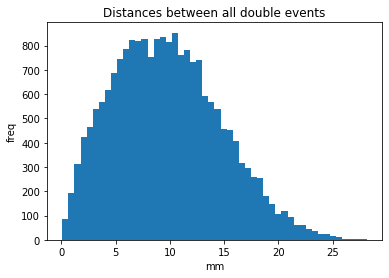

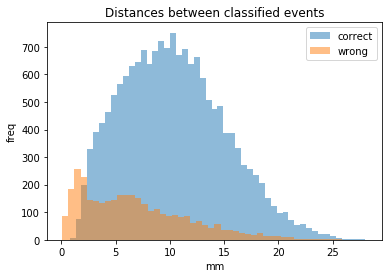

In [39]:
# Histograms
plt.hist(double_events[:,1], bins=50)
plt.xlabel("mm")
plt.ylabel("freq")
plt.title("Distances between all double events")
plt.show()
plt.hist(double_events[correct][:,1], bins=50, alpha=0.5, label="correct")
plt.hist(double_events[wrong][:,1], bins=50, alpha=0.5, label="wrong")
plt.xlabel("mm")
plt.ylabel("freq")
plt.title("Distances between classified events")
plt.legend()
plt.show()
